<a href="https://colab.research.google.com/github/edgleuma-abreu/IGTI/blob/main/Projeto_Aplicado_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTAÇÃO DE BIBLIOTECAS**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats

import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

import math
from sklearn.metrics import mean_squared_error

In [2]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

#from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs




# settings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
#Ler dados
df =pd.read_csv("dataset_pa_v2.csv", delimiter=";")

df_mem = df[['datahora', 'mem_usage']]
df_cpu = df[['datahora', 'cpu_usage']]

In [ ]:
df.head()

#df_mem.head()
#df_cpu.head()

,datahora,mem_usage,cpu_usage
0,02/10/22 14:00,223,6.37
1,02/10/22 15:00,224,6.07
2,02/10/22 16:00,224,6.31
3,02/10/22 17:00,224,6.18
4,02/10/22 18:00,224,6.28


In [ ]:
#Tamanho do dataset
df.shape

(337, 3)

In [ ]:
#Verificar valores nulos
df.isna().sum()

datahora     0
mem_usage    0
cpu_usage    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datahora   337 non-null    object 
 1   mem_usage  337 non-null    int64  
 2   cpu_usage  337 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.0+ KB


In [ ]:
#df.index = df[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")
#df_mem.index = df_mem[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")
#df_cpu.index = df_cpu[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")


##Verificar se as séries são estacionárias

In [ ]:
adfuller_test(df_mem['mem_usage'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8668
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3478. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [ ]:
adfuller_test(df_cpu['cpu_usage'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7565
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0648. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


**Ambas as séries são NÃO ESTACIONÁRIAS**

## Técnicas para transformar a série em ESTACIONÁRIA

**Memória**

In [ ]:
# Log function
log_series = pd.Series(np.log(df_mem['mem_usage'].values), index = df_mem['datahora'])
adfuller_test(log_series)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.973
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.2985. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [ ]:
# Removing the rolling mean
moving_average = df_mem['mem_usage'].rolling(window = 12).mean()
df_no_average = df_mem['mem_usage'].shift(periods = 11) - moving_average
no_mean_series = pd.Series(df_no_average.values, index = df_mem['datahora'])
no_mean_series.dropna(inplace = True)
adfuller_test(no_mean_series)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5544
 No. Lags Chosen       = 4
 Critical value 1%     = -3.451
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [ ]:


# Differentiating
diff_series = pd.Series(df_mem['mem_usage'].diff().values, index = df_mem['datahora'])
diff_series.dropna(inplace = True)

adfuller_test(diff_series)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4789
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


**CPU**


In [ ]:
#Log Function
log_series_cpu = pd.Series(np.log(df_cpu['cpu_usage'].values), index = df_cpu['datahora'])
adfuller_test(log_series_cpu)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1447
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0234. Rejecting Null Hypothesis.
 => Series is Stationary.


In [ ]:
# Removing the rolling mean
moving_average = df_cpu['cpu_usage'].rolling(window = 12).mean()
df_no_average = df_cpu['cpu_usage'].shift(periods = 11) - moving_average
no_mean_series_cpu = pd.Series(df_no_average.values, index = df_cpu['datahora'])
no_mean_series_cpu.dropna(inplace = True)
adfuller_test(no_mean_series_cpu)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2949
 No. Lags Chosen       = 5
 Critical value 1%     = -3.451
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [ ]:
# Differentiating
diff_series_cpu = pd.Series(df_cpu['cpu_usage'].diff().values, index = df_cpu['datahora'])
diff_series_cpu.dropna(inplace = True)

adfuller_test(diff_series_cpu)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1391
 No. Lags Chosen       = 1
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


##ARIMA - escolher parâmetros

**Memória**

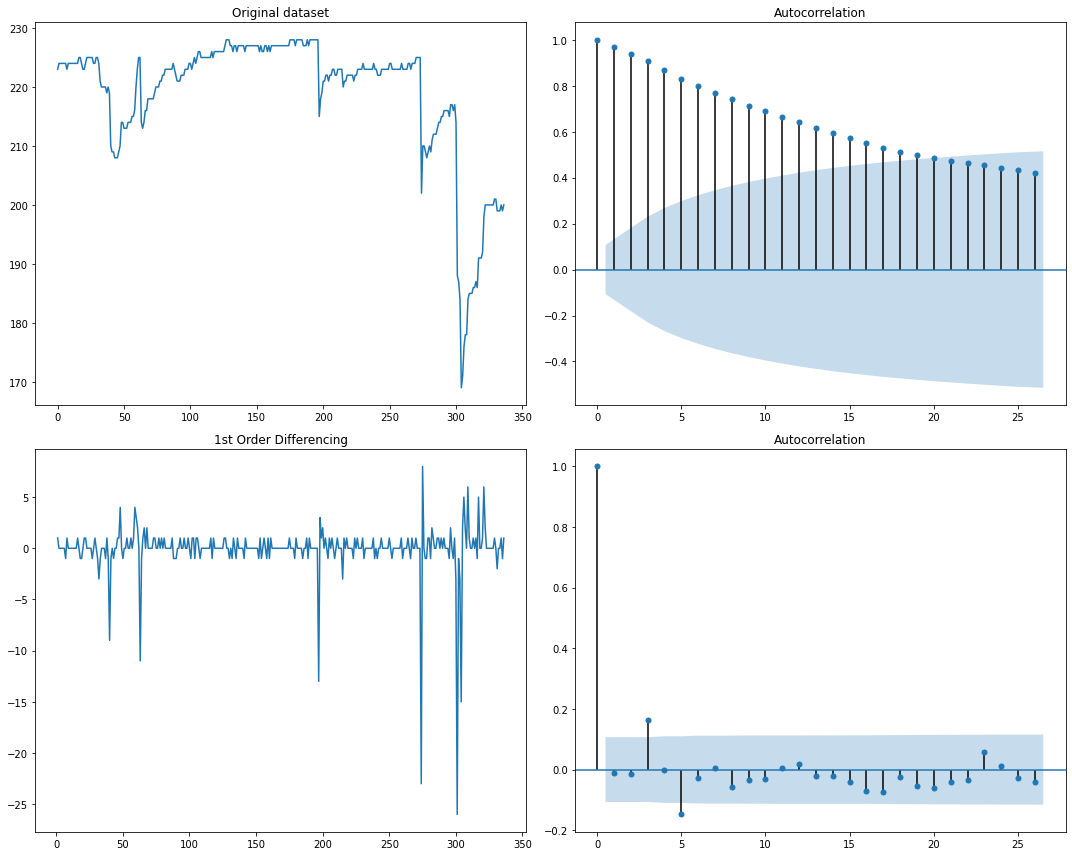

In [ ]:


# Original data set plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].plot(df_mem['mem_usage']); axes[0, 0].set_title('Original dataset')
plot_acf(df_mem['mem_usage'], ax=axes[0, 1])

# First order differencing
axes[1, 0].plot(df_mem['mem_usage'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_mem['mem_usage'].diff().dropna(), ax=axes[1, 1])



plt.tight_layout()
plt.show()

**CPU**

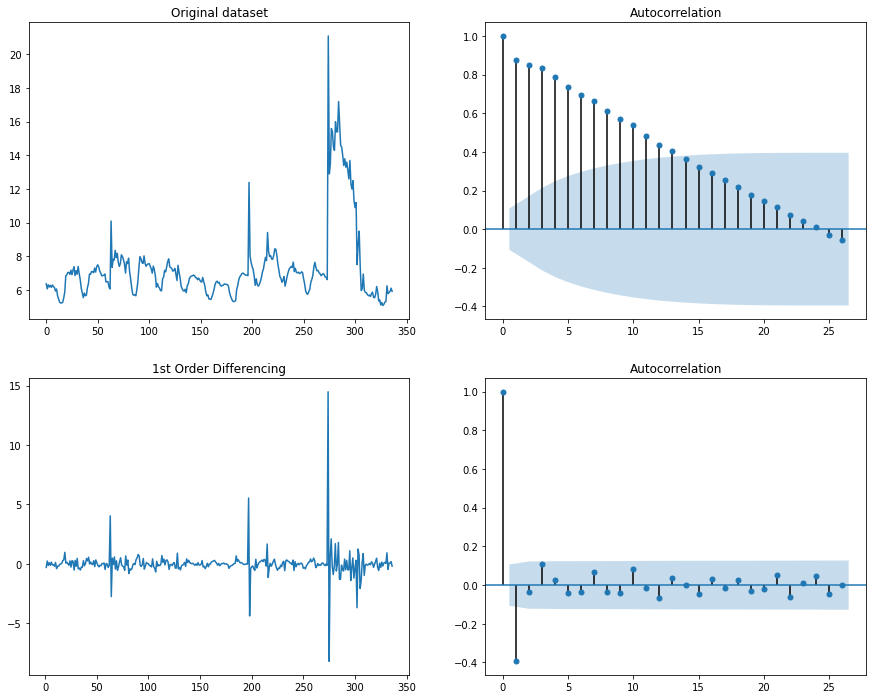

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original data set plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].plot(df_cpu['cpu_usage']); axes[0, 0].set_title('Original dataset')
plot_acf(df_cpu['cpu_usage'], ax=axes[0, 1])

# First order differencing
axes[1, 0].plot(df_cpu['cpu_usage'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_cpu['cpu_usage'].diff().dropna(), ax=axes[1, 1])

plt.show()

##Transformar em não estacionárias

In [ ]:
#Memória
first_diff_mem = df_mem['mem_usage'].diff() # Differencing the first order
first_diff_mem.dropna(inplace = True) # Removing problems

adfuller_test(first_diff_mem)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4789
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [ ]:
#CPU
first_diff_cpu = df_cpu['cpu_usage'].diff() # Differencing the first order
first_diff_cpu.dropna(inplace = True) # Removing problems

adfuller_test(first_diff_cpu)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1391
 No. Lags Chosen       = 1
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


##Encontrar p e q

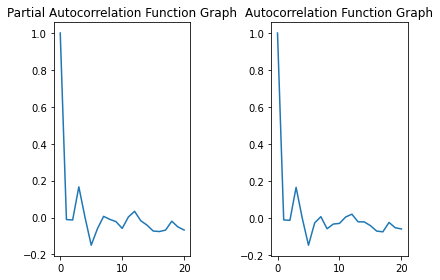

In [ ]:
from statsmodels.graphics.tsaplots import acf, pacf

lets_find_p_mem = pacf(first_diff_mem, nlags=20) # Limited the lags for better visualization
lets_find_q_mem = acf(first_diff_mem, nlags=20) 

# Plotting
plt.subplot(121)
plt.plot(lets_find_p_mem)
plt.title('Partial Autocorrelation Function Graph')

plt.subplot(122)
plt.plot(lets_find_q_mem)
plt.title('Autocorrelation Function Graph')
plt.tight_layout()

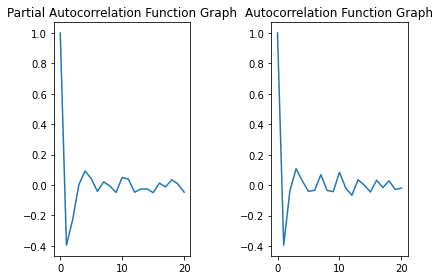

In [ ]:
from statsmodels.graphics.tsaplots import acf, pacf

lets_find_p_cpu = pacf(first_diff_cpu, nlags=20) # Limited the lags for better visualization
lets_find_q_cpu = acf(first_diff_cpu, nlags=20) 


# Plotting
plt.subplot(121)
plt.plot(lets_find_p_cpu)
plt.title('Partial Autocorrelation Function Graph')

plt.subplot(122)
plt.plot(lets_find_q_cpu)
plt.title('Autocorrelation Function Graph')
plt.tight_layout()

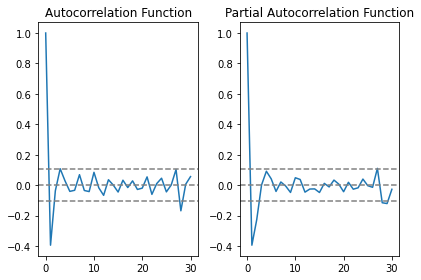

In [ ]:
#Outra opção de PLOT

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(first_diff_cpu, nlags=30)
lag_pacf = pacf(first_diff_cpu, nlags=30, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff_cpu)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff_cpu)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff_cpu)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff_cpu)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

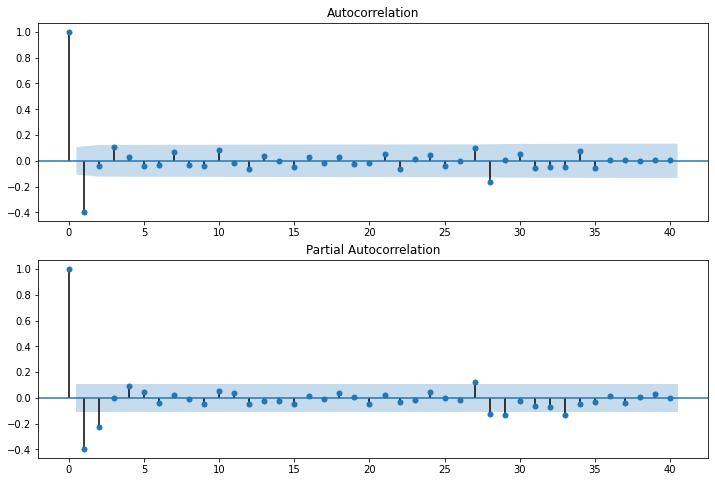

In [94]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff_cpu.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff_cpu, lags=40, ax=ax2)

In [97]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 9.8 MB 51.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [103]:
first_diff_cpu.shape

(336,)

numpy version: '1.21.6'
pmdarima version: '2.0.1'
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=867.382, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=671.858, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=734.529, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=645.707, Time=0.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=773.957, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=598.267, Time=0.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=621.560, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=565.456, Time=0.66 sec
 ARIMA(

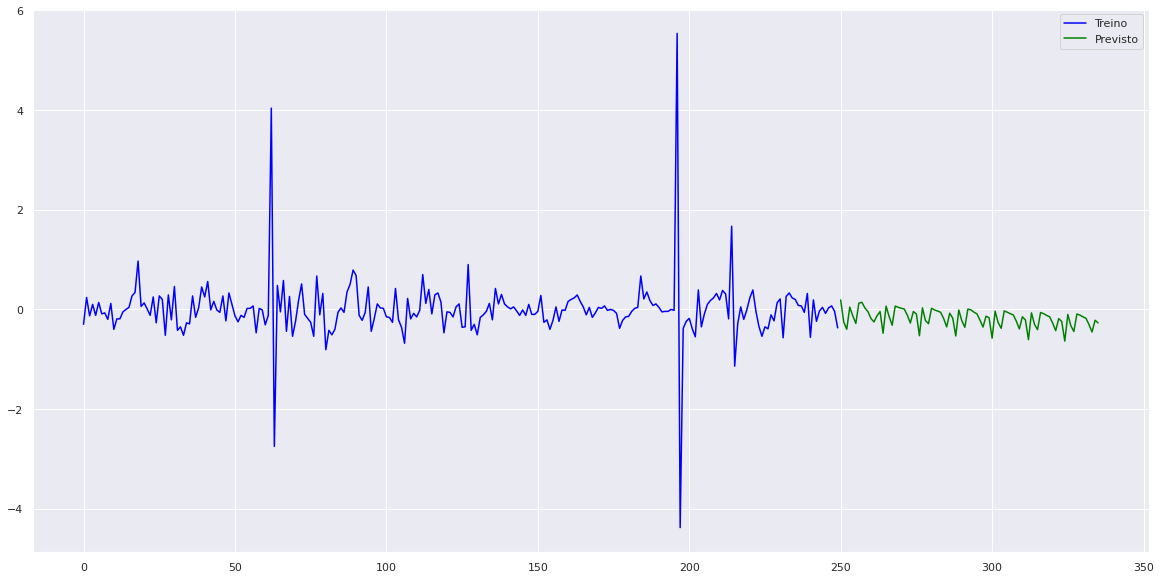

In [107]:
# fitting a stepwise model:



import pmdarima as pm
from pmdarima.model_selection import train_test_split

print('numpy version: %r' % np.__version__)
print('pmdarima version: %r' % pm.__version__)


# Load/split your data
y = first_diff_cpu
train, test = train_test_split(y, train_size=250)

# Fit your model
model = pm.auto_arima(train, start_p=1, start_q=1, max_p=4, max_q=4, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future






# #stepwise_fit = pm.auto_arima(first_diff_cpu, start_p=1, start_q=1, max_p=4, max_q=4, m=12,
#                              start_P=0, seasonal=True, d=1, D=1, trace=True,
#                              error_action='ignore',  # don't want to know if an order does not work
#                              suppress_warnings=True,  # don't want convergence warnings
#                              stepwise=True)  # set to stepwise

# #stepwise_fit.summary()

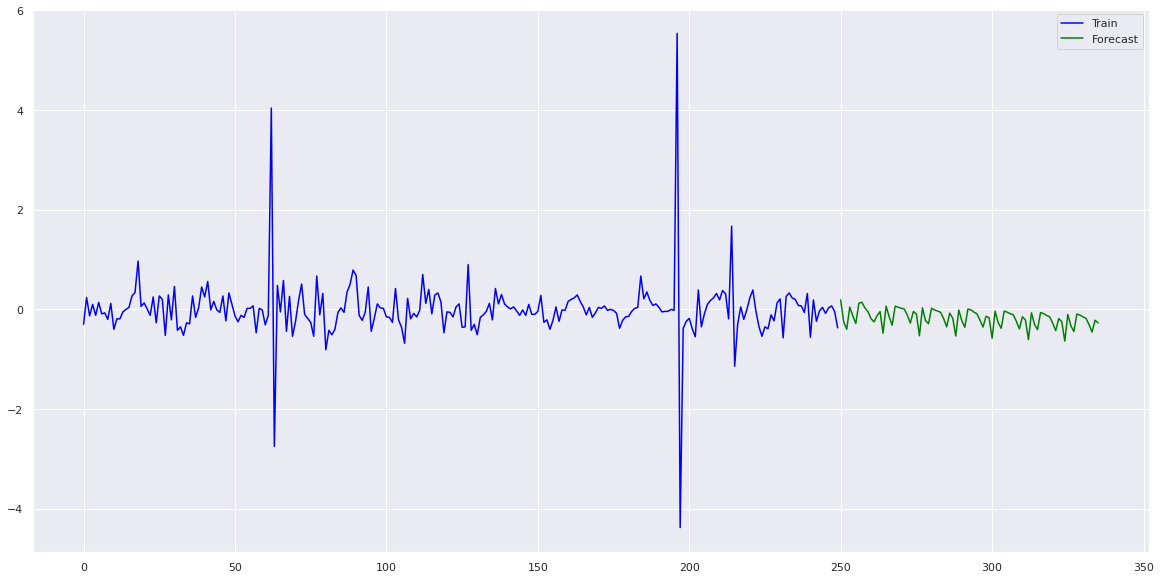

In [110]:
# Visualize the forecasts (blue=train, green=forecasts)
sns.set(rc={'figure.figsize':(20,10)})
x = np.arange(y.shape[0])
plt.plot(x[:250], train, c='blue')
plt.plot(x[250:], forecasts, c='green')
plt.legend (labels=['Train', 'Forecast'])
plt.show()

In [ ]:
print (metrics.mean_absolute_error(y_test, y_pred)
print (metrics.mean_squared_error(y_true, y_pred)
print(sqrt(metrics.mean_squared_error(y_true, y_pred))

In [ ]:
#eliminar a coluna DATE, pois ela já seria o indice
#df.drop("datahora", inplace=True, axis=1)



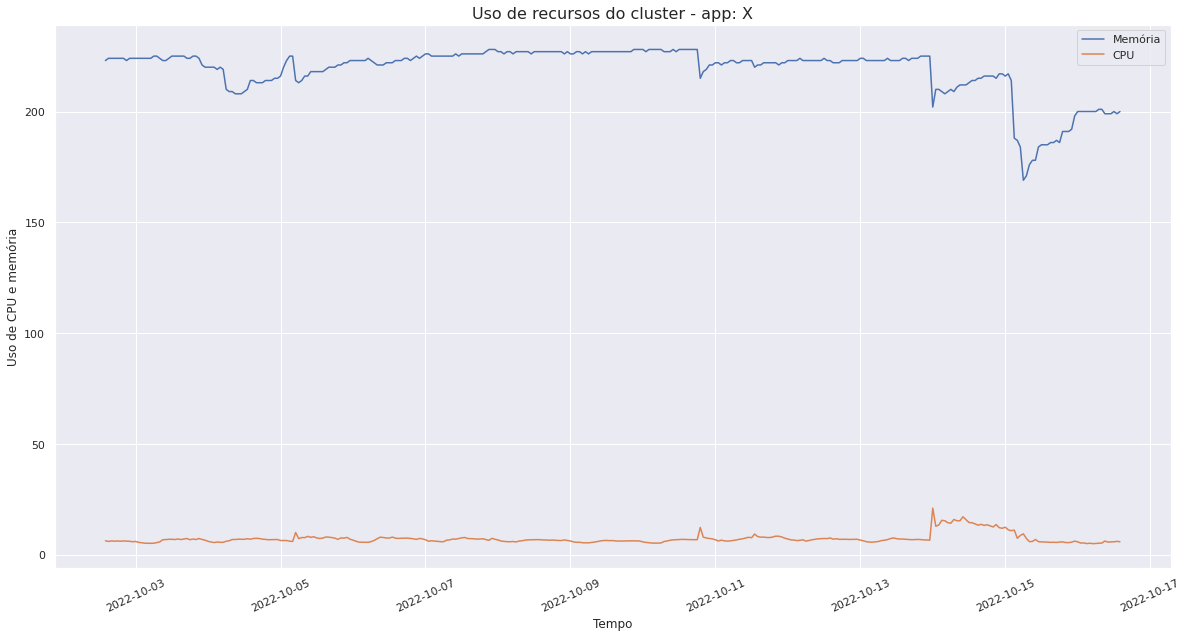

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})

#sns.lineplot(x='datahora', y='mem', data = df)
#sns.lineplot(x='datahora', y='cpu_usage', data = df)
plt.plot(df.index, df.mem_usage, df.cpu_usage);
plt.title("Uso de recursos do cluster - app: X", fontsize=16)
plt.ylabel("Uso de CPU e memória")
plt.xlabel("Tempo")

plt.xticks(rotation=25)

plt.legend( loc='middle right', labels=['Memória', 'CPU'])



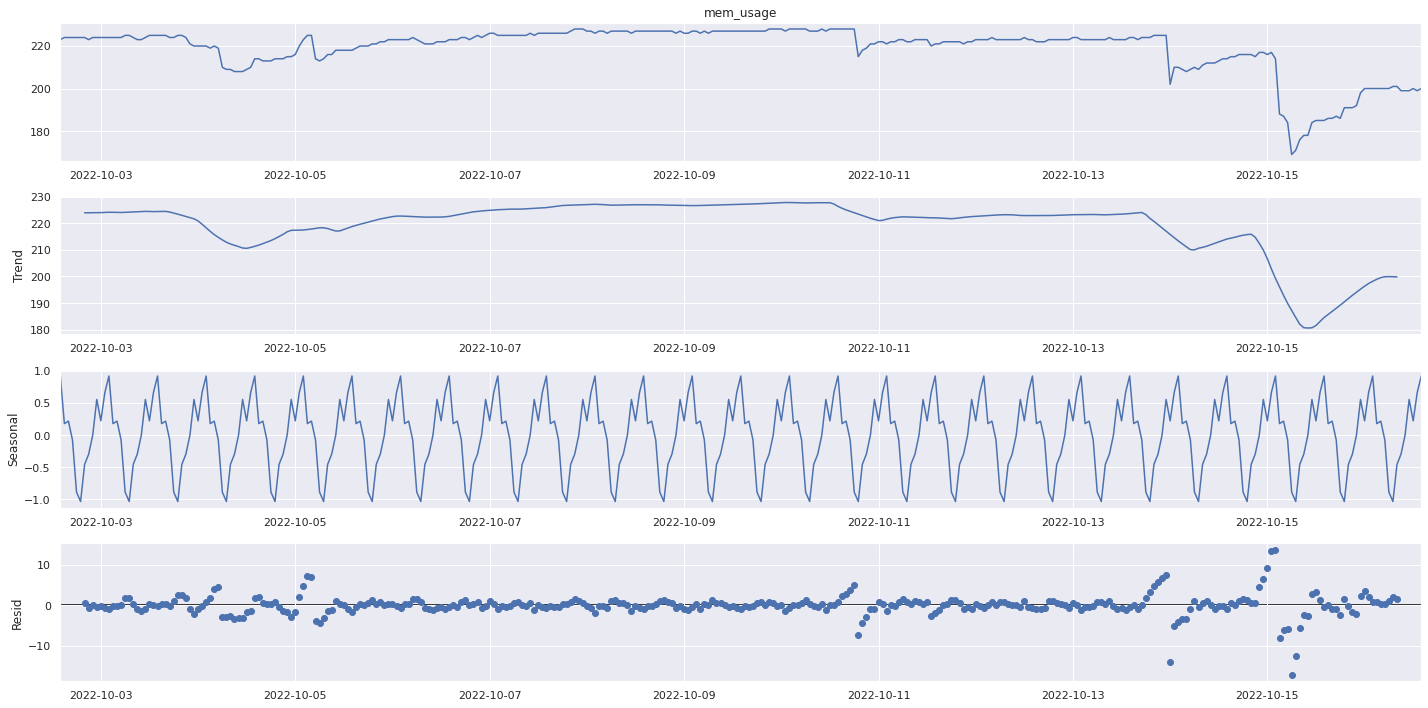

In [ ]:
#TODO: Entender parâmetros - additive ou multiplicative / qtde de periods / Não entendi como interpreta o ruído/ Dá para fazer CPU e mem juntos ou tem que fazer separado mesmo?
result_mem = seasonal_decompose(df['mem_usage'], model='additive', period=12)
fig = result_mem.plot()



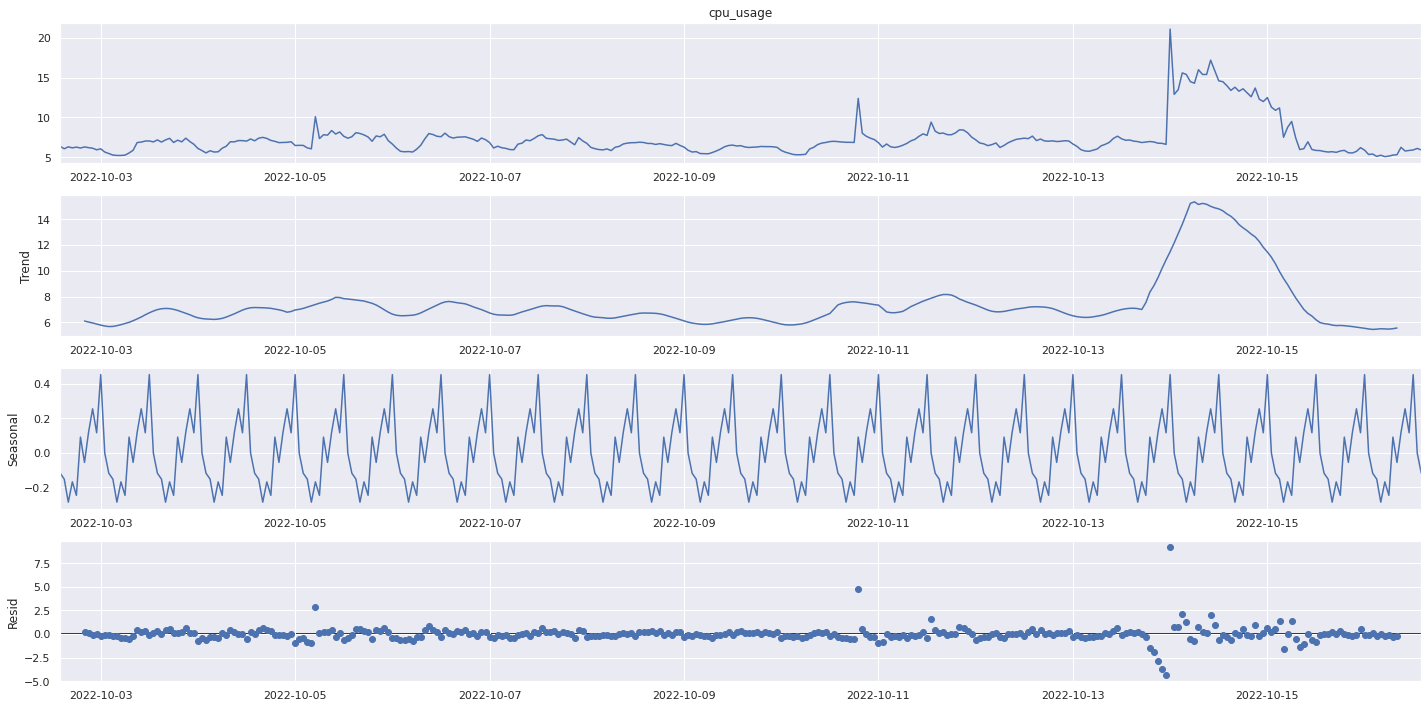

In [ ]:
result_cpu = seasonal_decompose(df['cpu_usage'], model='additive', period=12)
fig = result_cpu.plot()


In [ ]:
# Teste em cada coluna
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "mem_usage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8668
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3478. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "cpu_usage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7565
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0648. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [ ]:
# First Diff
df_firstdiff = df.diff().dropna() 

In [ ]:
for name, column in df_firstdiff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "mem_usage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4789
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "cpu_usage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1391
 No. Lags Chosen       = 1
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




AttributeError: ignored

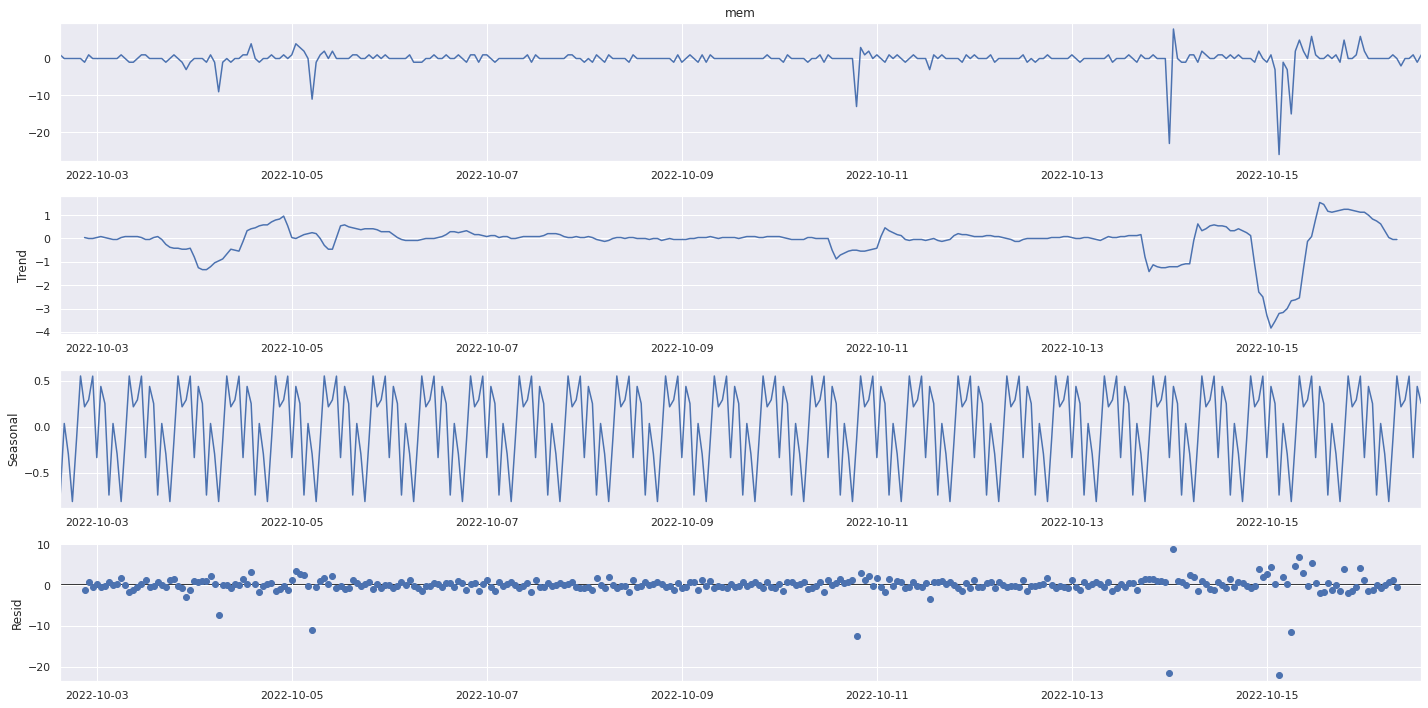

In [ ]:
#Plotar série depois de transformar em estacionária
#result_mem_new = seasonal_decompose(df_firstdiff['mem_usage'], model='additive', period=12)
#fig = result_mem_new.plot()


##CCC


In [ ]:
from statsmodels.graphics.tsaplots import acf, pacf

lets_find_p = pacf(first_diff, nlags=5) # Limited the lags for better visualization
lets_find_q = acf(first_diff, nlags=5) 

# Plotting
plt.subplot(121)
plt.plot(lets_find_p)
plt.title('Partial Autocorrelation Function Graph')

plt.subplot(122)
plt.plot(lets_find_q)
plt.title('Autocorrelation Function Graph')
plt.tight_layout()

#Prophet

In [ ]:
!pip install Prophet
from prophet import Prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
df_differenced.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(df_differenced) #fit the model with your dataframe

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxuxchg_e/sxaotf81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxuxchg_e/9vvtoaxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2281', 'data', 'file=/tmp/tmpxuxchg_e/sxaotf81.json', 'init=/tmp/tmpxuxchg_e/9vvtoaxt.json', 'output', 'file=/tmp/tmpxuxchg_e/prophet_modelwie0c5ic/prophet_model-20221018004447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:44:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:44:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:44:47 - cmdstanpy - ERROR - Chain [1] e

In [ ]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
17,1970-02-01 00:00:00.000000008,-7.161953e+14,-7.162361e+14,-7.161541e+14
18,1970-03-01 00:00:00.000000008,-1.363081e+15,-1.363206e+15,-1.362957e+15
19,1970-04-01 00:00:00.000000008,-2.079277e+15,-2.079510e+15,-2.079037e+15
20,1970-05-01 00:00:00.000000008,-2.772369e+15,-2.772743e+15,-2.771997e+15
21,1970-06-01 00:00:00.000000008,-3.488564e+15,-3.489103e+15,-3.488049e+15


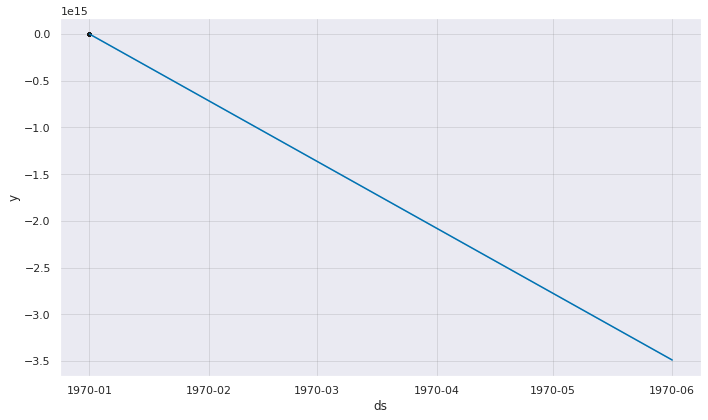

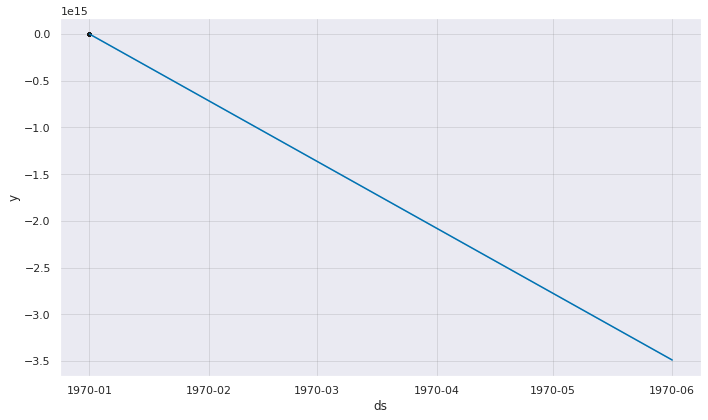

In [ ]:
model.plot(forecast)

**PREPARAÇÃO DOS DADOS**

##Fazer resample do dataset_pa e ver se fica bom ou pior :(

##Entender o decompose

In [ ]:
#Ler dados
df_teste =pd.read_csv("dataset_estudo.csv", delimiter=";")

In [ ]:
df_teste.shape

df_teste.head()

,datetime,cpu,mem,networkio
0,2022-07-25T03:48:30-03:00,0.000840,52142080,22.937.234.682.757.800
1,2022-07-25T03:48:45-03:00,0.000772,52432896,16.626.793.578.206.900
2,2022-07-25T03:49:00-03:00,0.000854,52162560,1.761.552.926.755.880
3,2022-07-25T03:49:15-03:00,0.000854,52162560,19.774.713.787.037.200
4,2022-07-25T03:49:30-03:00,0.000854,52162560,19.774.713.787.037.200


In [ ]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57598 entries, 0 to 57597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   57598 non-null  object 
 1   cpu        57598 non-null  float64
 2   mem        57598 non-null  object 
 3   networkio  57598 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [ ]:
df_teste.drop(['networkio'],axis=1)

,datetime,cpu,mem
0,2022-07-25 03:48:30-03:00,0.000840,52142080
1,2022-07-25 03:48:45-03:00,0.000772,52432896
2,2022-07-25 03:49:00-03:00,0.000854,52162560
3,2022-07-25 03:49:15-03:00,0.000854,52162560
4,2022-07-25 03:49:30-03:00,0.000854,52162560
...,...,...,...
57593,2022-07-25 15:42:00-03:00,0.000885,52207616
57594,2022-07-25 15:42:15-03:00,0.000898,52207616
57595,2022-07-25 15:42:30-03:00,0.000888,52207616
57596,2022-07-25 15:42:45-03:00,0.000882,52207616


In [ ]:
df_teste["datetime"] = pd.to_datetime,(df_teste["datetime"])

#

ValueError: ignored

In [ ]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57598 entries, 0 to 57597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype                                 
---  ------     --------------  -----                                 
 0   datetime   57598 non-null  datetime64[ns, pytz.FixedOffset(-180)]
 1   cpu        57598 non-null  float64                               
 2   mem        57598 non-null  object                                
 3   networkio  57598 non-null  object                                
dtypes: datetime64[ns, pytz.FixedOffset(-180)](1), float64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
df_teste_ajustado = df_teste.resample('H').mean()


df['date'] = pd.to_datetime(df['date'])
weekly_summary = df.story_point.resample('W', on='date').sum()

TypeError: ignored